<a href="https://colab.research.google.com/github/dbtronics/COMP551---Miniproject-3-Classification-of-Image-Data-/blob/main/Group_18_Miniproject_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import math
import pdb

# Multilayer Perceptron
Multilayer Perceptron Implementation with built-in Gradient Descent optimizer in fit() method

Implemention will take batch or individual sample units. It can be used with SGD or mini-batch SGD or batch GD. This needs to be mentioned in fit() with batch_size parameter.
* If batch_size = N i.e. takes in all samples, then it is Batch Gradient Descent
* If batch_size < N i.e. takes in some samples then it is Mini-Batch Gradient Descent
* If batch_size = 1 i.e. takes in individual samples, then it is Stochastic Gradient Descent

Assumes that all hidden layers have the SAME neurons

In [9]:
class MLP:
  def __init__ (self, input_neurons, output_neurons, hidden_layer=1,
               hidden_neurons=128,learning_rate=1e-2, activation="sigmoid", dropout=False, dropout_percent=0.2):
    # self.epochs = epochs
    self.hidden_layer = hidden_layer
    self.input_neurons = input_neurons
    self.hidden_neurons = hidden_neurons
    self.output_neurons = output_neurons
    # self.batch_size = batch_size # decides on mini/batch stochastic gradiant descent
    self.learning_rate = learning_rate
    # self.epsilon = epsilon
    self.activation = activation # decides on sigmoid, relu, leaky-relu, tanh activation
    # no. of weights dependent on hidden_layers
    self.weights = self.init_weights(self.hidden_layer) 
    # only activated if dropout is True
    self.dropout = dropout
    self.dropout_percent = dropout_percent
    self.dropout_node = self.init_dropout(self.hidden_layer) if self.dropout else None

  def init_weights(self, hidden_layer):
    if(hidden_layer==0):
      w = np.random.randn(self.input_neurons, self.output_neurons) * np.sqrt(1./self.output_neurons)
      return np.asarray([w])
    elif (hidden_layer==1):
      v = np.random.randn(self.input_neurons, self.hidden_neurons) * np.sqrt(1./self.hidden_neurons)
      w = np.random.randn(self.hidden_neurons, self.output_neurons) * np.sqrt(1./self.output_neurons)
      return np.asarray([v,w])
    elif (hidden_layer==2):
      v = np.random.randn(self.input_neurons, self.hidden_neurons) * np.sqrt(1./self.hidden_neurons)
      r = np.random.randn(self.hidden_neurons, self.hidden_neurons) * np.sqrt(1./self.hidden_neurons)
      w = np.random.randn(self.hidden_neurons, self.output_neurons) * np.sqrt(1./self.output_neurons)
      return np.asarray([v,r,w])
    else:
      print("# of hidden layer should be <= 2")
      return None

  def init_dropout(self, hidden_layer):
    if(hidden_layer>0):
      # d = np.random.rand(self.hidden_neurons)
      # d = d<0.5 # clamps value to 0 and 1 only
      random_index = np.random.permutation(self.hidden_neurons) # creates random index from 0 to M
      drop = np.ones(self.hidden_neurons) # intialize dropout vector
      drop[random_index[:int(self.hidden_neurons*self.dropout_percent)]] = 0 # dropout nodes on selective index
      return drop
    else: return None

  def fit(self, x_train, y_train, batch_size, epochs=1e3, epsilon=1e-2,): # add batchsize here rather than in __init__
    y_class = np.zeros((y_train.shape[0], np.max(y_train)+1))
    for i in range(y_train.shape[0]): y_class[i,y_train[i]] = 1

    batch_runs = math.ceil(y_train.shape[0]/batch_size)
    
    norm = np.array([np.inf])
    t=0
    while(np.any(norm>epsilon) and t<epochs):
      # pdb.set_trace()
      for batch_index in range(batch_runs): # batch_runs decides if it is mini-batch, stochastic or batch GD
        start = batch_index*batch_size
        end = (batch_index+1)*batch_size
        x_train_batch = x_train[start:end] if end<=y_train.shape[0] else x_train[start:]
        y_train_batch = y_class[start:end] if end<=y_train.shape[0] else y_class[start:] # N x C
        y_train_label_batch = y_train[start:end] if end<=y_train.shape[0] else y_train[start:] # N
        # print(x_train.shape)
        # print(x_train_batch.shape)
        yh = self.forward_pass(x_train_batch)
        dweights = self.back_prop(yh, y_train_batch)
        self.update_weights(np.asarray(dweights))
      # yh = self.forward_pass(x_train)
      # dweights = self.back_prop(yh, y_class)
      # self.update_weights(np.asarray(dweights))

      # takes into account of 0 layer
      norm = [np.linalg.norm(dweights)] if len(dweights)==1 else [np.linalg.norm(g) for g in dweights]
      norm = np.array(norm)
      # norm = [np.linalg.norm(g) for g in dweights]
      # print("Epoch: ", t, " with accuracy of: ", self.eval_acc(np.argmax(yh, axis=-1), y_train))
      # print("Norm: ", norm)
      t+=1

  def activation_function(self, z, derivative=False):
    if(self.activation=="sigmoid"):
      return sigmoid(z)*(1-sigmoid(z)) if derivative else sigmoid(z)
      # if derivative: return sigmoid(z)*(1-sigmoid(z))
      # else: return sigmoid(z)
    elif(self.activation=="tanh"):
      return 1-np.square(tanh(z)) if derivative else tanh(z)
      # if derivative: return 1-np.square(tanh(z))
      # else: return tanh(z)
    elif(self.activation=="relu"):
      return 1*(z>0) if derivative else relu(z)
      # if derivative: return 1 * (z>0)
      # else: return relu(z)
    elif(self.activation=="leaky-relu"):
      temp = 1*(z>0)
      return (np.array(temp==0, dtype=float)*0.1+temp) if derivative else leaky_relu(z)
      # if derivative:
      #   return 1 if (z>0) else 0.1
      # else: return leaky_relu(z)
    else:
      print("invalid activation function")
      return None
      
  def forward_pass(self, x_train):
    f1 = x_train # N x D
    self.f_params = []
    if(self.hidden_layer==0): # no dropout here since it doesn't have hidden layer
      # input --> output
      f2 = np.dot(f1, self.weights[0]) # N x C
      f3 = softmax(f2) # N x C
      self.f_params = [f1, f2, f3]
      return f3

    elif (self.hidden_layer==1):
      # input --> first layer
      f2 = np.dot(f1, self.weights[0]) # N x M
      f3 = self.activation_function(f2) # N x M
      #DROPOUT REGULARIZATION
      f3 = f3*self.dropout_node if (self.dropout) else f3

      # first layer --> output
      f4 = np.dot(f3, self.weights[1]) # N x C
      f5 = softmax(f4) # N x C
      # print("f1", f1[:3])
      # print("f2", f2[:3])
      # print("f3", f3[:3])
      # print("f4", f4[:3])
      # print("f5", f5[:3])
      self.f_params = [f1, f2, f3, f4, f5]
      return f5

    elif (self.hidden_layer==2):
      # input --> first layer
      f2 = np.dot(f1, self.weights[0]) # N x M
      f3 = self.activation_function(f2) # N x M
      #DROPOUT REGULARIZATION
      f3 = f3*self.dropout_node if (self.dropout) else f3

      # first layer --> second layer
      f4 = np.dot(f3, self.weights[1]) # N x M
      f5 = self.activation_function(f4) # N x M
      #DROPOUT REGULARIZATION
      f5 = f5*self.dropout_node if (self.dropout) else f5

      # second layer --> output
      f6 = np.dot(f5, self.weights[2]) # N x C
      f7 = softmax(f6) # N x C
      self.f_params = [f1, f2, f3, f4, f5, f6, f7]
      return f7
    
    else:
      print("No forward pass")
      return None

  
  def back_prop(self, y_pred, y_train):
    N = y_pred.shape[0]
    b1 = y_pred-y_train # N x C
    b1 /= np.max(y_train)+1 # average out derivative of cost function
    # print('y_pred', y_pred[:3])
    # print('p_train', y_train[:3])
    if(self.hidden_layer==0): # No dropout here since it doesn't have a hidden layer
      f1, f2, f3 = self.f_params

      e1 = b1 * softmax_diff(f2) # N x C
      b2 = np.dot(f1.T, e1)/N # D x C

      return [b2]

    elif (self.hidden_layer==1):
      f1, f2, f3, f4, f5 = self.f_params
      # print("b1", b1[:3])
      # print("f4", f4[:3])
      e1 = b1 * softmax_diff(f4) # N x C
      b2 = np.dot(f3.T, e1)/N # M x C
      # print("e1", e1[:3])
      # print("f3", f3[:3])
      # print("b2", b2[:3])
      b3 = np.dot(e1, self.weights[1].T) # N x M
      # DROPOUT REGULARIZATION
      b3 = b3*self.dropout_node if self.dropout else b3

      e2 = self.activation_function(f2, derivative=True)
      b4 = np.dot(f1.T, b3*e2)/N # D x M
      # print("b4", b4[:3])
      # print("b2", b2[:3])
      return [b4, b2]

    elif (self.hidden_layer==2):
      f1, f2, f3, f4, f5, f6, f7 = self.f_params

      e1 = b1 * softmax_diff(f6) # N x C
      b2 = np.dot(f5.T, e1)/N # M x C

      b3 = np.dot(e1, self.weights[2].T) # N x M
      # DROPOUT REGULARIZATION
      b3 = b3*self.dropout_node if self.dropout else b3

      e2 = self.activation_function(f4, derivative=True) # N x M
      b4 = np.dot((b3*e2).T, f3)/N # M x M

      b5 = np.dot(b3*e2, self.weights[1].T) # N x M
      # DROPOUT REGULARIZATION
      b5 = b5*self.dropout_node if self.dropout else b5

      e3 = self.activation_function(f2, derivative=True) # N x M
      b6 = np.dot(f1.T, (b5*e3))/N # D x M

      return [b6, b4, b2]
    
    else:
      print("No backpropagation")
      return None
  
  def update_weights(self, dweights):
    self.weights -= self.learning_rate * dweights

  def predict(self, x_test):
    yh = self.forward_pass(x_test)
    return np.argmax(yh, axis=-1)

  def eval_acc(self, y_pred, y_test):
    acc = y_pred==y_test
    # print("Prediction: 0 --> %d ; 1 --> %d ; 2 --> %d ; 3 --> %d ; 4 --> %d ; 5 --> %d ; 6 --> %d ; 7 --> %d ; 8 --> %d ; 9 --> %d"  % (np.sum(y_pred == 0), np.sum(y_pred==1), np.sum(y_pred==2), np.sum(y_pred==3), np.sum(y_pred==4), np.sum(y_pred==5), np.sum(y_pred==6), np.sum(y_pred==7), np.sum(y_pred==8), np.sum(y_pred==9)))
    return np.sum(acc)/len(y_test)
    # return(np.mean((y_pred==y_test)))



# Cross-Validation and kFold Validation Testing

In [10]:
def cross_validation(x_train, y_train, L, i):
  block = int(1/L * x_train.shape[0])
  val_mask = np.zeros(x_train.shape[0], dtype=bool)
  start = block*i
  end = block*(i+1)
  val_mask[start:end] = True # select validation set only
  x_tr = x_train[val_mask]
  y_tr = y_train[val_mask]
  x_val = x_train[val_mask==False] # invert indices boolean to get train set
  y_val = y_train[val_mask==False] # invert indices boolean to get train set
  return x_tr, y_tr, x_val, y_val

In [11]:
def kFoldCV(model, x, y, L, batch_size):
  train_acc, val_acc = [], []
  for k in range(L):
    x_train, y_train, x_val, y_val = cross_validation(x, y, L, k)
    model.fit(x_train, y_train, batch_size)
    y_val_pred = model.predict(x_val)
    y_train_pred = model.predict(x_train)
    train_acc.append(model.eval_acc(y_train_pred, y_train))
    val_acc.append(model.eval_acc(y_val_pred, y_val))
    print("%d/%d fold completed" %(k+1,L))
  print("Mean [training, validation] accuracy of [%.3f, %.3f]" % 
        (np.mean(train_acc), np.mean(val_acc)))
  return train_acc, val_acc


## Activation Function
Sigmoid, ReLu, Leaky ReLu, tanh for intermediate layer 

Softmax and derivative for classification and gradient update

In [12]:
sigmoid = lambda z: 1./ (1 + np.exp(-z))

relu = lambda z: np.maximum(0, z)

tanh = lambda z: np.tanh(z)

leaky_relu = lambda z: np.maximum(0.1*z, z)

# prevent overflow in exponential using z.max()
softmax = lambda z: np.exp(z-z.max()) / np.sum(np.exp(z-z.max()), axis = -1)[:, None] 
softmax_diff = lambda z: softmax(z)*(1-softmax(z))


# Main Body of Code
## Importing Data and normalization
* Normalization from [0, 255] --> [0, 1]
* Important to reduce overflow in exponent operation

In [13]:
mnist_dataset = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

print("Train image shape: ", train_images.shape)
print("Train label shape: ", train_labels.shape)
print("\nTest image shape: ", test_images.shape)
print("Test label shape: ", test_labels.shape)

# normalize pixel values to domain of 0 and 1
x_train = train_images/255
y_train = train_labels

x_test = test_images/255
y_test = test_labels

#vectorize the images
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

fraction = 1.0

x_train = x_train[:int(x_train.shape[0]*fraction)]
y_train = y_train[:int(y_train.shape[0]*fraction)]

x_test = x_test[:int(x_test.shape[0]*fraction)]
y_test = y_test[:int(y_test.shape[0]*fraction)]

Train image shape:  (60000, 28, 28)
Train label shape:  (60000,)

Test image shape:  (10000, 28, 28)
Test label shape:  (10000,)


## Selecting optimal training data for optimal performance on test set

* Performance metric is based on accuracy on validation set
* Using k=3 in KFoldCV for cross-validation testing (constant)
* Using batch_size of 50 for Mini-Batch Gradient Descent (constant)
* Using 1 hidden layer MLP (constant)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


1/3 fold completed
2/3 fold completed
3/3 fold completed
Mean [training, validation] accuracy of [0.953, 0.828]
5 percent test fraction completed with mean accuracy of 0.828
1/3 fold completed
2/3 fold completed
3/3 fold completed
Mean [training, validation] accuracy of [0.951, 0.846]
10 percent test fraction completed with mean accuracy of 0.846
1/3 fold completed
2/3 fold completed
3/3 fold completed
Mean [training, validation] accuracy of [0.949, 0.857]
15 percent test fraction completed with mean accuracy of 0.857
1/3 fold completed
2/3 fold completed
3/3 fold completed
Mean [training, validation] accuracy of [0.948, 0.863]
20 percent test fraction completed with mean accuracy of 0.863


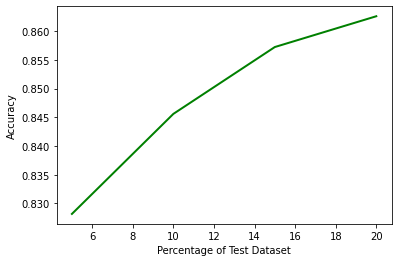


0.20 fraction has the best performance



In [14]:
training_fraction = [0.05, 0.10, 0.15, 0.20] # looping from 5-20% of training data
training_fraction_test_performance = np.zeros(len(training_fraction))
best_training_fraction = 0

for fr in range(len(training_fraction)):
  x_train_fraction = x_train[:int(x_train.shape[0]*training_fraction[fr])]
  y_train_fraction = y_train[:int(y_train.shape[0]*training_fraction[fr])]
  model_1hl = MLP(x_test.shape[1], np.max(y_test)+1, activation = "relu", hidden_layer=1)
  x_train_acc, x_val_acc = kFoldCV(model_1hl, x_train_fraction, y_train_fraction, 3, 50)
  training_fraction_test_performance[fr] = np.mean(x_val_acc)
  print("%d percent test fraction completed with mean accuracy of %.3f"%
        (int(training_fraction[fr]*100), training_fraction_test_performance[fr]))
plt.plot([fr*100 for fr in training_fraction], training_fraction_test_performance, linewidth=2, color='green')
plt.xlabel("Percentage of Test Dataset")
plt.ylabel("Accuracy")
plt.show()
best_training_fraction = training_fraction[np.argmax(training_fraction_test_performance)] # select best validation acc
print("\n%.2f fraction has the best performance\n" % best_training_fraction)

## Comparing Test Accuracy of 0, 1, and 2 Hidden Layers
* With epsilon of 0.01
* With learning rate of 0.01
* With epoch of 1,000
* With mini-batch gradient descent of 50
* Activation = ReLU
* Hidden Layer nodes = 128

0 hidden layer completed with accuracy of 0.801


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


1 hidden layer completed with accuracy of 0.847


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


2 hidden layer completed with accuracy of 0.100

Best hidden layer of MLP is: 1


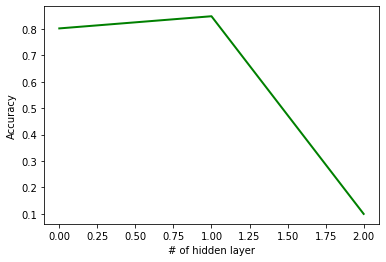

In [15]:
hidden_layer = [0, 1, 2]
model_array = []
layer_acc = np.zeros(len(hidden_layer))
best_layer=0 # select the best out of layer_acc array
x_train = x_train[:int(x_train.shape[0]*best_training_fraction)] # values retrieved from before testing
y_train = y_train[:int(y_train.shape[0]*best_training_fraction)] # values retrieved from before testing

for layer_index in range(len(hidden_layer)):
  model = MLP(x_test.shape[1], np.max(y_test)+1, activation = "relu", hidden_layer=hidden_layer[layer_index])
  model.fit(x_train, y_train, 50)
  model_array.append(model)
  yh = model.predict(x_test)
  layer_acc[layer_index] = model.eval_acc(yh, y_test)
  print("%d hidden layer completed with accuracy of %.3f" %(hidden_layer[layer_index], layer_acc[layer_index]))
best_layer = np.argmax(layer_acc)
plt.plot(hidden_layer, layer_acc, linewidth=2, color='green')
plt.xlabel("# of hidden layer")
plt.ylabel("Accuracy")
print("\nBest hidden layer of MLP is: %d"%best_layer)

## Comparing Test Accuracy with different Activation Function
* Sigmoid
* Relu
* Leaky Relu
* tanh

Keeping the following parameters constant
* Hidden layer neurons = 128 (default)
* Number of hidden layers = 2
* epochs = 1,000
* epsilon and learning rate = 0.01
* batch size of 50 for mini-batch GD

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


sigmoid activation completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


relu activation completed
leaky-relu activation completed
tanh activation completed


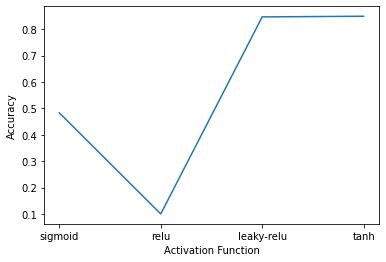


Best activation function is tanh


In [16]:
activation_array = ["sigmoid", "relu", "leaky-relu", "tanh"]
best_activation=""
act_acc = np.zeros(len(activation_array))
for activation_index in range(len(activation_array)):
  model = MLP(x_test.shape[1], np.max(y_test)+1, activation = activation_array[activation_index], hidden_layer=2)
  model.fit(x_train, y_train, 50)
  yh = model.predict(x_test)
  act_acc[activation_index] = model.eval_acc(yh, y_test)
  print("%s activation completed" % activation_array[activation_index])
best_activation = activation_array[np.argmax(act_acc)]
plt.plot(activation_array, act_acc)
plt.xlabel("Activation Function")
plt.ylabel("Accuracy")
plt.show()
print("\nBest activation function is %s" % best_activation)

## Dropout Regularization
* Has tunable hyper-perimeter (dropout_percent)
  * Hyperperimeter domain {0.05, 0.1, 0.15, 0.20, 0.25, 0.30}

Following are perimeter configuration:

* Hidden layer neurons = 128 (default)
* Number of hidden layers = 2
* epochs = 1,000
* epsilon and learning rate = 0.01
* batch size of 50 for mini-batch GD
* ReLU activation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


5.0 dropout percentage completed with accuracy of 0.1000
10.0 dropout percentage completed with accuracy of 0.1000
15.0 dropout percentage completed with accuracy of 0.1000
20.0 dropout percentage completed with accuracy of 0.1000
25.0 dropout percentage completed with accuracy of 0.1000
30.0 dropout percentage completed with accuracy of 0.1000
35.0 dropout percentage completed with accuracy of 0.1000
40.0 dropout percentage completed with accuracy of 0.1000
45.0 dropout percentage completed with accuracy of 0.1000
50.0 dropout percentage completed with accuracy of 0.1000


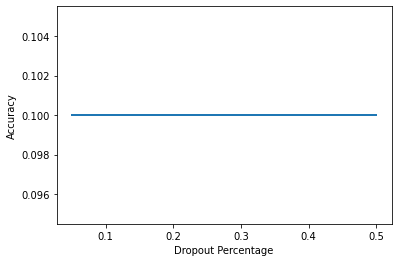


Best dropout percentage is 5


In [18]:
dropout_percentage = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50] # going from 5-50% dropout
# dropout_performance = np.zeros(len(dropout_percentage))
dropout_acc = np.zeros(len(dropout_percentage))
best_dropout_percentage = 0

for dropout_index in range(len(dropout_percentage)):
  model = MLP(x_test.shape[1], np.max(y_test)+1, activation = "relu", hidden_layer=2,
            dropout=True, dropout_percent=dropout_percentage[dropout_index])
  model.fit(x_train, y_train, 50)
  yh = model.predict(x_test)
  dropout_acc[dropout_index] = model.eval_acc(yh, y_test)
  print("%.1f dropout percentage completed with accuracy of %.4f" %
        (int(dropout_percentage[dropout_index]*100), dropout_acc[dropout_index]))
plt.plot(dropout_percentage, dropout_acc, linewidth=2)
plt.xlabel("Dropout Percentage")
plt.ylabel("Accuracy")
plt.show()
best_dropout_percentage = dropout_percentage[np.argmax(dropout_acc)]
print("\nBest dropout percentage is %.1d" % int(best_dropout_percentage*100))

## Best Network Perimeters
Based on previous results, the optimal perimeters are:
* 15% Training Dataset
* tanh Activation
* Dropout percentage of 20%
* Hidden layer of 1

Keeping following perimeter configuration
* Hidden layer neurons = 128 (default)
* epochs = 1,000
* epsilon and learning rate = 0.01
* batch size of 50 for mini-batch GD

In [19]:
optimal_model = MLP(x_train.shape[1], np.max(y_train)+1, activation="tanh", dropout=True, dropout_percent=0.2)
optimal_model.fit(x_train, y_train, 50)
y_train_pred = optimal_model.predict(x_train)
y_test_pred = optimal_model.predict(x_test)
print("Prediction complete and based on the optimal model, following are the accuracies:\n\n")
print("Training Dataset accuracy of %.2f" % optimal_model.eval_acc(y_train_pred, y_train))
print("Unseen Dataset accuracy of %.2f" % optimal_model.eval_acc(y_test_pred, y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Prediction complete and based on the optimal model, following are the accuracies:


Training Dataset accuracy of 0.93
Unseen Dataset accuracy of 0.85


TEST AREA

In [21]:
model = MLP(x_train.shape[1], np.max(y_train)+1, hidden_layer=2, activation="relu", learning_rate=2e-3)
model.fit(x_train, y_train, 50)
yh = model.predict(x_test)
print(model.eval_acc(yh, y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.8316
